In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
import sys; sys.path.append("../../offline/")
import sparse, geom, utils

In [3]:
path_to_data = "../../data/sparse/" # scratch/sparse on Maxwell
path_to_aux = "../../data/aux/" # scratch/benedikt/aux on Maxwell
path_to_geometry = "../../geometry/"
path_to_recons = "../../data/recons/"

## Dead pixels
These are pixels with no response as detected by background powder with zero-valued pixels

In [4]:
run = 595
with h5py.File(path_to_aux + "r%04d_powder.h5" %run, 'r') as f:
    powder_modules = f['data'][:]
deadpixels = (powder_modules.sum(axis=0)==0)

## mask strong pixels in the per-cell background powder

In [5]:
cutoff = 200
belowstrong = (powder_modules < cutoff).all(axis=0)

## Customized mask for panels 3,4,8,15
Pixels have been masked manually

In [6]:
filename = path_to_aux + "det_lowq.h5"
with h5py.File(filename) as f:
    custom = np.transpose(f['mask'][:].reshape(4,128,128), axes=(0,2,1))
goodpixels = np.ones((16,128,512), dtype=np.bool)
goodpixels[3,:,-128:]  = (custom[0] == 0)
goodpixels[4,:,-128:]  = (custom[1] == 0)
goodpixels[8,:,-128:]  = (custom[2] == 0)
goodpixels[15,:,-128:] = (custom[3] == 0)

## Mask bad asic

In [7]:
badasic = np.zeros((16,128,512), dtype=np.bool)
badasic[5,64:,3*64:4*64] = True

## Combine all masks into a single goodpixel mask

In [8]:
goodpixels &= (~deadpixels)
goodpixels &= (~badasic)
goodpixels &= (belowstrong)

## Plot assembled mask

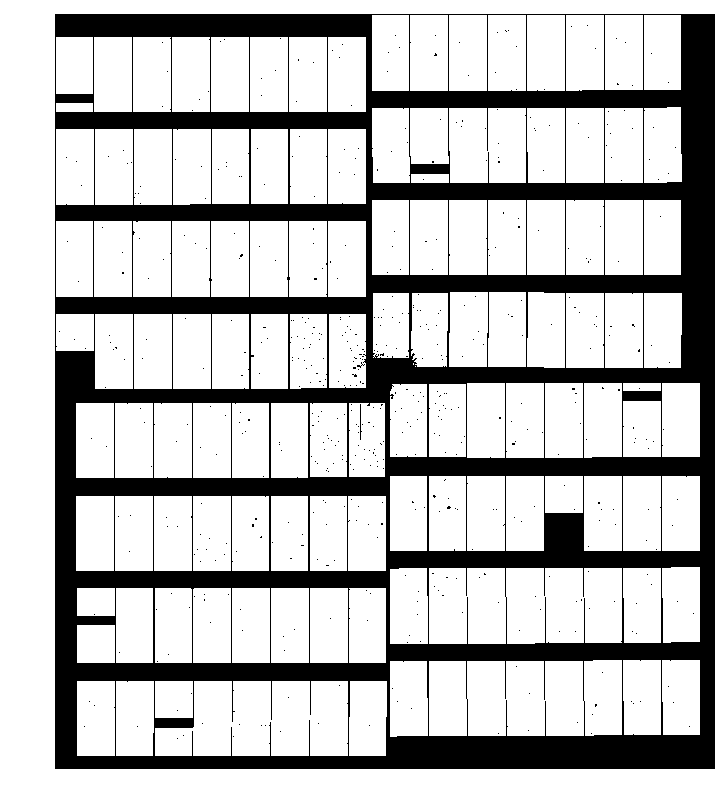

In [9]:
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.imshow(utils.assemble(goodpixels, path_to_geometry + "b1.geom"), cmap='gray')
plt.savefig("../../plots/goodpixels.png", bbox_inches='tight')
plt.show()

## Save mask to file

In [10]:
with h5py.File(path_to_aux + "goodpixels.h5", "w") as f:
    f['data/data'] = goodpixels

## Save updated mask to lowq detector file

In [11]:
lowq_mask = np.zeros((4,128,128), dtype='u1')
lowq_mask[0][~goodpixels[3,:,-128:]]  = 2
lowq_mask[1][~goodpixels[4,:,-128:]]  = 2
lowq_mask[2][~goodpixels[8,:,-128:]]  = 2
lowq_mask[3][~goodpixels[15,:,-128:]] = 2

In [12]:
os.system("cp %s %s" %(path_to_aux + "det_lowq.h5", path_to_recons + "det/det_lowq7.h5"))

0

In [14]:
filename = path_to_recons + "det/det_lowq7.h5"
with h5py.File(filename, "a") as f:
    f['mask'][:] = np.transpose(lowq_mask, axes=(0,2,1)).ravel()